# Model Vehicle Sales Analysis Using SQL & Python

### By Abhimanyu Verma

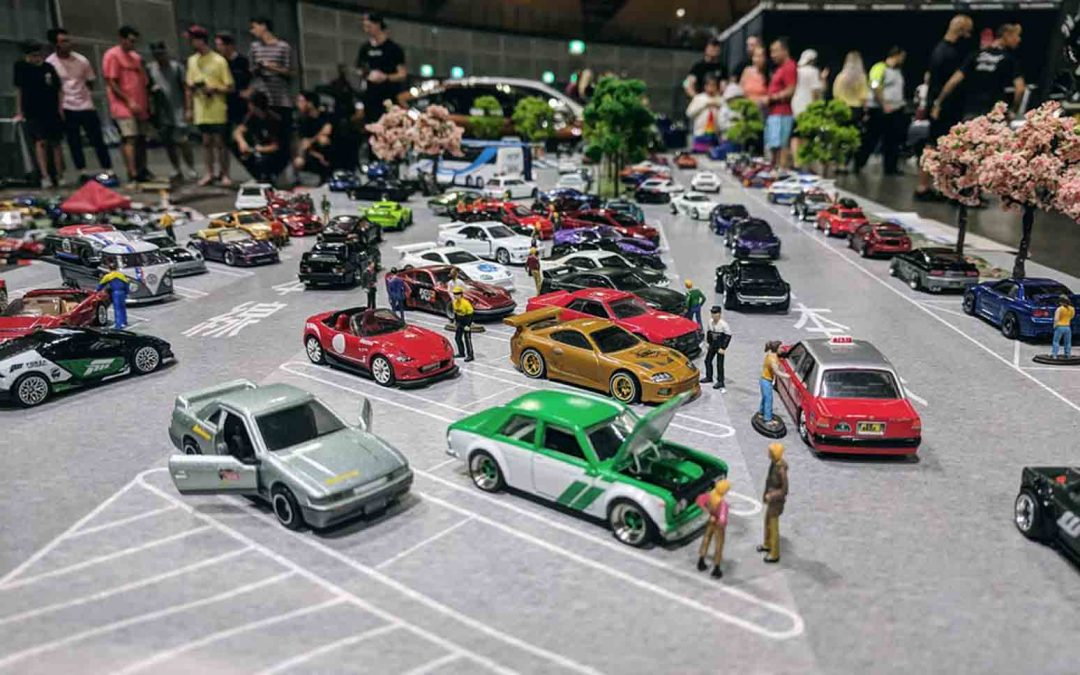

## Introduction

This database is of a fictitious wholesale distributor of die cast models of vehicles ranging from vintage cars to planes. They have customers in more than 15 countries around the world.

The company has asked us to go over their dataset and analyse it to make some essential decisions related to potential future expansion.

The goal of this project is to go over the questions that they have and extract answers based on the data.

## Connecting to the database

In [1]:
%%capture
%load_ext sql
%sql sqlite:///stores.db

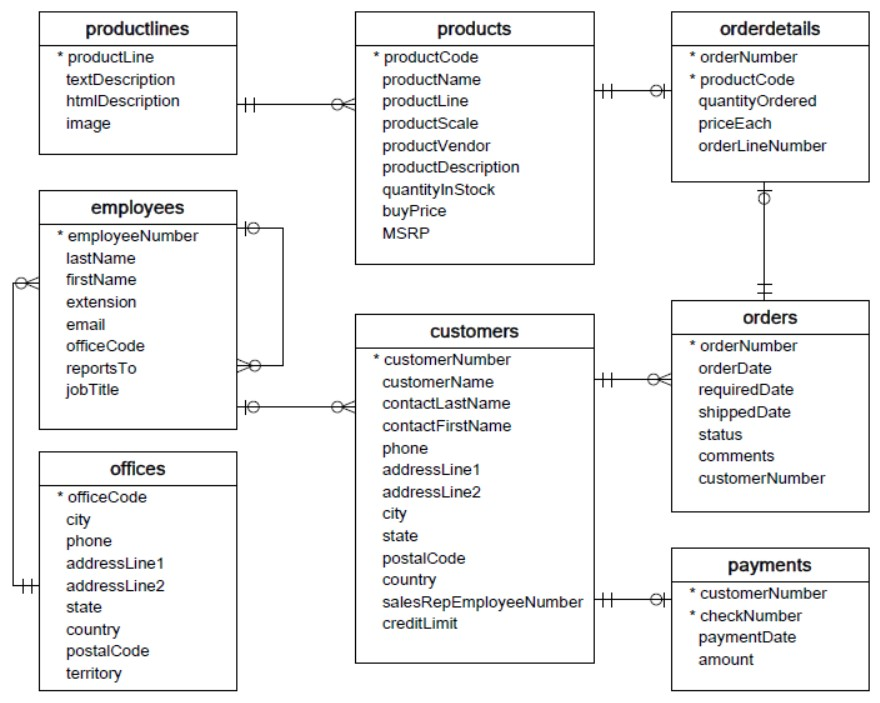

Before we proceed with analysing the database, it would be best to summarize the same.

## Understanding the tables of the database

In [2]:
%%sql
SELECT '' AS Table_Names,'' AS Number_of_Attributes,'' AS Number_of_Rows
UNION ALL
SELECT 'Customer',13,(SELECT COUNT(*)
                        FROM customers)
UNION ALL
SELECT 'Products',9,(SELECT COUNT(*)
                        FROM products)
UNION ALL
SELECT 'ProductLines',4,(SELECT COUNT(*)
                        FROM productlines)
UNION ALL
SELECT 'Orders',7,(SELECT COUNT(*)
                        FROM orders)
UNION ALL
SELECT 'OrderDetails',5,(SELECT COUNT(*)
                        FROM orderdetails)
UNION ALL
SELECT 'Payments',4,(SELECT COUNT(*)
                        FROM payments)
UNION ALL
SELECT 'Employees',8,(SELECT COUNT(*)
                        FROM employees)
UNION ALL
SELECT 'Offices',9,(SELECT COUNT(*)
                        FROM offices)

 * sqlite:///stores.db
Done.


Table_Names,Number_of_Attributes,Number_of_Rows
,,
Customer,13,122
Products,9,110
ProductLines,4,7
Orders,7,326
OrderDetails,5,2996
Payments,4,273
Employees,8,23
Offices,9,7


## Installing libraries for analysis & connecting it to the database

In [3]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

conn = sqlite3.connect('stores.db')
df = pd.read_sql_query("""SELECT * 
                            FROM offices;""", conn)
df

,officeCode,city,phone,addressLine1,addressLine2,state,country,postalCode,territory
0,1,San Francisco,+1 650 219 4782,100 Market Street,Suite 300,CA,USA,94080,NA
1,2,Boston,+1 215 837 0825,1550 Court Place,Suite 102,MA,USA,02107,NA
2,3,NYC,+1 212 555 3000,523 East 53rd Street,apt. 5A,NY,USA,10022,NA
3,4,Paris,+33 14 723 4404,43 Rue Jouffroy D'abbans,None,None,France,75017,EMEA
4,5,Tokyo,+81 33 224 5000,4-1 Kioicho,None,Chiyoda-Ku,Japan,102-8578,Japan
5,6,Sydney,+61 2 9264 2451,5-11 Wentworth Avenue,Floor #2,None,Australia,NSW 2010,APAC
6,7,London,+44 20 7877 2041,25 Old Broad Street,Level 7,None,UK,EC2N 1HN,EMEA


The company has a number of offices and each office has multiple employees. Every customer is associated to a sales person whose employee ID is recorded in the `salesRepEmployeeNumber` column of the Customer table.

The company has many products that are categorised in to product lines. Every incoming order lists certain order specific details related to a product and those details are listed in the `OrderDetails` table. The orders associated to the items in the `OrderDetails` table are separately tracked in the Orders table.

The `status` column in the order tracks the progress of the order from when it is received to when it is shipped out. The different status' of an order has been listed below.

Once the order is shipped out, customers seem to be paying for their orders in a cumulative manner. Customers have the option of utilising credit based on the `CreditLimit` column the in the `Customer` table. While going over the comments column of the `Orders` table it was noticed that an order can be put on hold if a user has gone beyond their credit limit for a particular order. The order is processed only after the payment is cleared.

## Reading the Data

In [4]:
%%sql
SELECT status AS Order_Status,COUNT(status) AS Number_of_Orders
  FROM orders
 GROUP BY status
 ORDER BY Number_of_Orders DESC

 * sqlite:///stores.db
Done.


Order_Status,Number_of_Orders
Shipped,303
In Process,6
Cancelled,6
Resolved,4
On Hold,4
Disputed,3


We shall be analyzing only orders that have shipped out since all of the other orders require payment clearence. Orders and Order Details associated to shipped orders will therefore need to be filtered out.

#### A. Creating view to filter only orders with status 'shipped'

In [5]:
%%sql
CREATE VIEW shipped_orders AS
SELECT orders.*,
       ROUND(SUM(orderdetails.quantityOrdered*orderdetails.priceEach),2) AS Order_Total,
       ROUND(SUM((orderdetails.priceEach - products.buyPrice)*orderdetails.quantityOrdered),2) AS Order_Profit
  FROM orders
  JOIN orderdetails
    ON orders.orderNumber=orderdetails.orderNumber
  JOIN products
    ON orderdetails.productCode=products.productCode
 GROUP BY orders.orderNumber
HAVING status = 'Shipped';

SELECT *
  FROM shipped_orders
 LIMIT 5;

 * sqlite:///stores.db
Done.
Done.


orderNumber,orderDate,requiredDate,shippedDate,status,comments,customerNumber,Order_Total,Order_Profit
10100,2003-01-06,2003-01-13,2003-01-10,Shipped,None,363,10223.83,3940.36
10101,2003-01-09,2003-01-18,2003-01-11,Shipped,Check on availability.,128,10549.01,5236.74
10102,2003-01-10,2003-01-18,2003-01-14,Shipped,None,181,5494.78,2135.94
10103,2003-01-29,2003-02-07,2003-02-02,Shipped,None,121,50218.95,18827.11
10104,2003-01-31,2003-02-09,2003-02-01,Shipped,None,141,40206.2,15680.8


#### B. Creating view to filter order details associated to orders with 'shipped' status

In [6]:
%%sql
CREATE VIEW shipped_order_details AS
SELECT *
  FROM orderdetails
 WHERE orderNumber IN (SELECT orderNumber
                         FROM shipped_orders);

SELECT *
  FROM shipped_order_details
 LIMIT 5;

 * sqlite:///stores.db
Done.
Done.


orderNumber,productCode,quantityOrdered,priceEach,orderLineNumber
10100,S18_1749,30,136,3
10100,S18_2248,50,55.09,2
10100,S18_4409,22,75.46,4
10100,S24_3969,49,35.29,1
10101,S18_2325,25,108.06,4


## Reviewing the questions put forward by the company

We have been asked to make assessments related to the following questions:

1. Can you identify the top 10 models that are in demand ?
2. Identify the top five customers for us.
3. What countries should be targeted by our marketing for maximum returns ?
4. Identify the best and worst categories for each country.
5. How was the sales performance over the entire sales time period ?
6. We want to expand our sales team, however we need to know the performance of our current sales team.
7. Should we focus on getting new customers or engaging our existing customers to increase our sales ?
8. Are there items in our stock that have not been sold for a long time ?

Clearly each of these questions are not direct. Hence we will make the assessments and answer these questions using assumptions.



## Analysis

#### A. Identifying products that are in high demand & have great selling value

Our first question is about identifying items that are in high demand in most orders and highly profitable to the company. Stocking up on these items will ensure that we can fulfil the market needs and simultaneously make some extra cash.

The formula for low stock and product performance is:

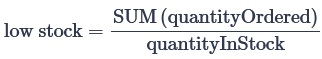

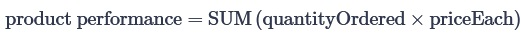

Using these formulas let's Identify the products that are in high demand & have great selling value.

In [7]:
%%sql
WITH
get_lowstock AS(
SELECT productCode,
       (SUM(od.quantityOrdered)*1.0)/ 
                       (SELECT quantityInStock
                          FROM products
                         WHERE od.productCode = productCode) AS low_stock
 FROM shipped_order_details od
GROUP BY productCode
ORDER BY low_stock DESC
LIMIT 10
)

SELECT products.productName AS Model_Name,
       products.quantityInStock AS Quantity_on_Hand,
       COUNT(*) AS No_of_Orders,
       SUM(shipped_order_details.quantityOrdered) AS Total_Quantity_Ordered,
       ROUND(SUM(shipped_order_details.quantityOrdered*shipped_order_details.priceEach),2) AS Total_Sales,
       products.productLine AS Prouct_Line
  FROM shipped_order_details
  JOIN products
    ON products.productCode = shipped_order_details.productCode
 WHERE shipped_order_details.productCode IN (SELECT productCode
                                               FROM get_lowstock)
 GROUP BY products.productCode
 ORDER BY Total_Sales DESC
LIMIT 10;

 * sqlite:///stores.db
Done.


Model_Name,Quantity_on_Hand,No_of_Orders,Total_Quantity_Ordered,Total_Sales,Prouct_Line
1968 Ford Mustang,68,26,909,157749.08,Classic Cars
1928 Mercedes-Benz SSK,548,26,813,121946.96,Vintage Cars
1997 BMW F650 ST,178,26,920,81440.8,Motorcycles
2002 Yamaha YZR M1,600,27,992,73670.64,Motorcycles
1960 BSA Gold Star DBD34,15,28,1015,67193.49,Motorcycles
F/A 18 Hornet 1/72,551,24,872,63905.6,Planes
1928 Ford Phaeton Deluxe,136,25,846,52518.05,Vintage Cars
1996 Peterbilt 379 Stake Bed with Outrigger,814,26,895,52046.16,Trucks and Buses
1911 Ford Town Car,540,22,709,38730.32,Vintage Cars
Pont Yacht,414,22,770,38061.72,Ships


These are the top 10 models that are in high demand as seen by `Total_Sales` column. 

The highest profit generating model is **1968 Ford Mustang** while the highest ordered model is **1960 BSA Gold Star DBD34**.

The highest sales generating product line is **Motorcycles** as it appears 3 times in top 5 and has a collective sale of 222,304.93.

#### B. Identifying the top 5 customers

In [8]:
%%sql
CREATE VIEW customer_profit_report AS
SELECT shipped_orders.customerNumber AS customer_id,
       ROUND(SUM(shipped_order_details.quantityOrdered * (shipped_order_details.priceEach - products.buyPrice)),2) AS profit,
       COUNT(*) AS no_of_orders
  FROM shipped_orders
  JOIN shipped_order_details
    ON shipped_order_details.orderNumber=shipped_orders.orderNumber
  JOIN products
    ON shipped_order_details.productCode=products.productCode
 GROUP BY shipped_orders.customerNumber;

SELECT customers.contactLastName||", "||customers.contactFirstName AS Name,
       customers.city AS City,
       customers.country AS Country,
       customer_profit_report.profit AS Profit_Earned
  FROM customers
  JOIN customer_profit_report
    ON customers.customerNumber = customer_profit_report.customer_id
 WHERE customer_profit_report.customer_id IN (SELECT customer_id
                                                FROM customer_profit_report
                                               ORDER BY profit DESC
                                               LIMIT 5)
 ORDER BY customer_profit_report.profit DESC;

 * sqlite:///stores.db
Done.
Done.


Name,City,Country,Profit_Earned
"Freyre, Diego",Madrid,Spain,263439.51
"Nelson, Susan",San Rafael,USA,232494.29
"Young, Jeff",NYC,USA,72370.09
"Ferguson, Peter",Melbourne,Australia,70311.07
"Natividad, Eric",Singapore,Singapore,60477.38


#### C. Analysing profits earned by each country

Marketing is a costly affair. We need to identify markets where our strategy will yield the most customers. Besides attracting customers, we should be able to get high value customers to increase our profits.

Hence, we will focus on the following parameters:

1. The number of customers in each country
2. The percentage of profit contributed by each country
3. The profit generated per customer
4. The profit percentage by each country

This analysis should help to decide which countries to focus marketing on to increase profits.

In [9]:
%%sql
SELECT customers.country AS Country,
          COUNT(*) AS No_of_Customers,
          ROUND(SUM(customer_profit_report.profit),2) AS Profit_Earned,
          ROUND(SUM(customer_profit_report.profit)/COUNT(*),2) AS Profit_Per_Customer,
          ROUND((SUM(customer_profit_report.profit) * 100.0 / 
                                                            (SELECT SUM(profit)
                                                             FROM customer_profit_report)), 2) AS Profit_Percentage
     FROM customers
     JOIN customer_profit_report
       ON customers.customerNumber = customer_profit_report.customer_id
    GROUP BY customers.country
    ORDER BY Profit_Earned DESC;

 * sqlite:///stores.db
Done.


Country,No_of_Customers,Profit_Earned,Profit_Per_Customer,Profit_Percentage
USA,35,1214220.48,34692.01,34.32
France,12,397728.61,33144.05,11.24
Spain,5,376924.39,75384.88,10.66
Australia,5,201879.08,40375.82,5.71
New Zealand,4,165096.92,41274.23,4.67
UK,5,155313.0,31062.6,4.39
Italy,4,144459.86,36114.97,4.08
Finland,3,117239.33,39079.78,3.31
Singapore,2,101782.55,50891.28,2.88
Canada,3,78858.78,26286.26,2.23


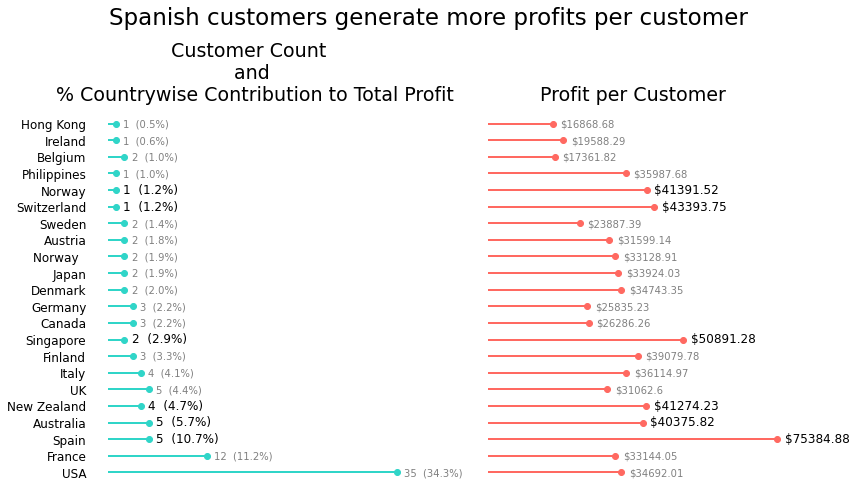

In [10]:
global_profit_report = pd.read_sql_query(
"""SELECT customers.country AS Country,
          COUNT(*) AS No_of_Customers,
          ROUND(SUM(customer_profit_report.profit),2) AS Profit_Earned,
          ROUND(SUM(customer_profit_report.profit)/COUNT(*),2) AS Profit_Per_Customer,
          ROUND((SUM(customer_profit_report.profit) * 100.0 / 
                                                            (SELECT SUM(profit)
                                                             FROM customer_profit_report)), 1) AS Profit_Percentage
     FROM customers
     JOIN customer_profit_report
       ON customers.customerNumber = customer_profit_report.customer_id
    GROUP BY customers.country
    ORDER BY Profit_Earned DESC;""", conn
)

fig = plt.figure(figsize=(12,7))

#Plot the customer count and profit generated in each country
ax1 = fig.add_subplot(1,2,1)
 
#Remove spines
for each_key in ax1.spines.keys():
    ax1.spines[each_key].set_visible(False)
    
#Plot Customer count
ax1.hlines(y=global_profit_report['Country'],
           xmin=0,
           xmax=global_profit_report['No_of_Customers'],
           color='#30D5C8',
           linewidth=2)
ax1.scatter(y=global_profit_report['Country'],
            x=global_profit_report['No_of_Customers'],
            color='#30D5C8')

#Beautify plot
ax1.tick_params(axis='y',left=False,labelsize=12)
ax1.tick_params(axis='x',bottom=False,labelbottom=False)

#Select specific values for annotation
big_spend_countries = [global_profit_report.iloc[i,0] for i in range(len(global_profit_report)) if global_profit_report.iloc[i,3]>40000]
size = [12 if global_profit_report.iloc[i,0]in big_spend_countries else 10 for i in range(len(global_profit_report)) ]
palette = ['black' if global_profit_report.iloc[i,0] in big_spend_countries else 'grey' for i in range(len(global_profit_report))]

#Annotate plot
for i in range(len(global_profit_report)):
    ax1.text(s=str(global_profit_report.iloc[i,1])+'  '+'('+str(global_profit_report.iloc[i,4])+'%'+')',
             x=global_profit_report.iloc[i,1]+0.9,
             y=i-0.2,
             size=size[i],
             color=palette[i])
ax1.set_title('Customer Count \n and \n % Countrywise Contribution to Total Profit',size=19,loc='center')

#Plot Profit per customer
ax2 = fig.add_subplot(1,2,2)

#Remove spines
for each_key in ax2.spines.keys():
    ax2.spines[each_key].set_visible(False)
    
#Plot Profit per customer
ax2.hlines(y=global_profit_report['Country'],
           xmin=0,
           xmax=global_profit_report['Profit_Per_Customer'],
           color='#ff6961',
           linewidth=2)
ax2.scatter(y=global_profit_report['Country'],
            x=global_profit_report['Profit_Per_Customer'],
            color='#ff6961')

#Beautify plot
ax2.tick_params(axis='y',left=False,labelsize=14,labelleft=False)
ax2.tick_params(axis='x',bottom=False,labelbottom=False)

#Select specific values for annotation
size = [12 if global_profit_report.iloc[i,3]>40000 else 10 for i in range(len(global_profit_report)) ]
palette = ['black' if global_profit_report.iloc[i,3]>40000 else 'grey' for i in range(len(global_profit_report)) ]

#Annotate plot
for i in range(len(global_profit_report)):
    ax2.text(s='$'+str(global_profit_report.iloc[i,3]),
             x=global_profit_report.iloc[i,3]+2000,
             y=i-0.2,
             size=size[i],
             color=palette[i])
ax2.set_title('Profit per Customer',size=19,loc='center')

#Title Of the graph
plt.suptitle("Spanish customers generate more profits per customer", size=23,x=0.50)
plt.tight_layout()
plt.show()

* Clearly, the interest for model vehicles in countries like USA and France standout, more so in the USA than France.
* **Spain, Australia, New Zealand, Singapore, Switzerland and Norway** have been highlightes in the graph because the customers from these countries generate a profit of atleast $40000.
* The Asian market is underrepresented since there are only 6 customers from 4 countries namely Singapore, Japan, Philipines and Hong Kong.
* Countries from South America and Africa are absent altogether.
* It is notable that while the USA is a major market, customers in different 10 countries spend more per customer than USA.

#### D. Identifying the best & worst product lines in different countries

Since we are allowed to make assumptions, we shall go with the quantity of the product line being ordered to judge the best and worst of product lines in each country.

In [11]:
%%sql
WITH
--#Join products and orderdetails 
order_category AS(
SELECT orderdetails.orderNumber,
       products.productLine
  FROM products
  JOIN orderdetails
    ON products.productCode=orderdetails.productCode
),

--#Join customers and orders
country_order AS(
SELECT customers.country,
       orders.orderNumber
  FROM orders
  JOIN customers
    ON orders.customerNumber=customers.customerNumber
),

--#Combine the above joins
country_category AS(
SELECT country_order.country AS Country,
       order_category.productLine AS Category
  FROM country_order
  JOIN order_category
    ON country_order.orderNumber=order_category.orderNumber
),

--#List all categories and their counts along with each country
country_category_count AS(
SELECT Country,
       Category,
       COUNT(Category) AS category_count
  FROM country_category
 GROUP BY Country,Category
)

--#Select the category with the most and least count
SELECT Country,
       (SELECT Category
          FROM country_category_count
         GROUP BY Country
        HAVING Country=c.Country AND category_count=MAX(category_count)) AS Best_Category,
       (SELECT Category
          FROM country_category_count
         GROUP BY Country
        HAVING Country=c.Country AND category_count=MIN(category_count)) AS Worst_Category
  FROM country_category_count c
 GROUP BY Country

 * sqlite:///stores.db
Done.


Country,Best_Category,Worst_Category
Australia,Vintage Cars,Trains
Austria,Classic Cars,Ships
Belgium,Vintage Cars,Planes
Canada,Trucks and Buses,Motorcycles
Denmark,Classic Cars,Planes
Finland,Classic Cars,Trains
France,Classic Cars,Trains
Germany,Classic Cars,Ships
Hong Kong,Planes,Motorcycles
Ireland,Classic Cars,Trucks and Buses


* Classics Cars is the most preferred product line in almost all countries while Trains are the least preferred.
* Switzerland shows that Classic Cars are it's best and worst lines because this is the only line ordered by the Swiss.

Seeing as how Classic Car models are quite popular in most countries, it would be interesting to find out the contribution of the different product lines towards the overall profits made.

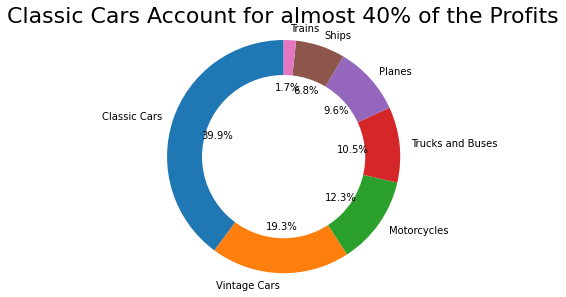

In [12]:
product_line_profit = pd.read_sql_query(
"""SELECT products.productLine AS Product_Category,
          ROUND(SUM((orderdetails.priceEach-products.buyPrice)*orderdetails.quantityOrdered),2) AS Profits_by_Category,
          ROUND((SUM((orderdetails.priceEach-products.buyPrice)*orderdetails.quantityOrdered)* 100.0 / 
                                                                              (SELECT SUM(profit)
                                                                                 FROM customer_profit_report)), 2) AS Percentage
     FROM orderdetails
     JOIN products
       ON orderdetails.productCode=products.productCode
    GROUP BY Product_Category
    ORDER BY Profits_by_Category DESC;""", conn
)

#Pie chart
labels = product_line_profit['Product_Category']
sizes = product_line_profit['Percentage']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

#Draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
ax1.set_title("Classic Cars Account for almost 40% of the Profits",size=22)
plt.show()

* Just as seen earlier, Classic Cars are the most sold product line and Trains are the least favoured.
* Vintage Cars makes up for nearly one-fifth of the total profits earned by the company.

#### E. Analysing profits over the entire sales time period

Monthly sales performance can be viewed from multiple perspectives. We could look at it from a sales perspective i.e the number of individual orders processed on a monthly basis or the cumulative total of all orders each month.

However, since we are talking about performance we shall focus on monthly sales performance based on the profits we have been making during each month. The more the profits for a month, the better the month has been.

In [13]:
%%sql
SELECT CAST(SUBSTR(orderDate,1,4) AS INT)*100+CAST(SUBSTR(orderDate,6,7) AS INT) AS Year_Month,
       CAST(SUBSTR(orderDate,1,4) AS INT) AS Year,
       CAST(SUBSTR(orderDate,6,7) AS INT) AS Month,
       ROUND(SUM(Order_Profit),2) AS Profit
FROM shipped_orders
GROUP BY Year_Month
HAVING Year_Month < 200501
ORDER BY Year_Month

 * sqlite:///stores.db
Done.


Year_Month,Year,Month,Profit
200301,2003,1,45820.95
200302,2003,2,51980.32
200303,2003,3,66103.02
200304,2003,4,73846.81
200305,2003,5,71586.99
200306,2003,6,58229.57
200307,2003,7,82073.59
200308,2003,8,70195.88
200309,2003,9,93855.53
200310,2003,10,174281.84


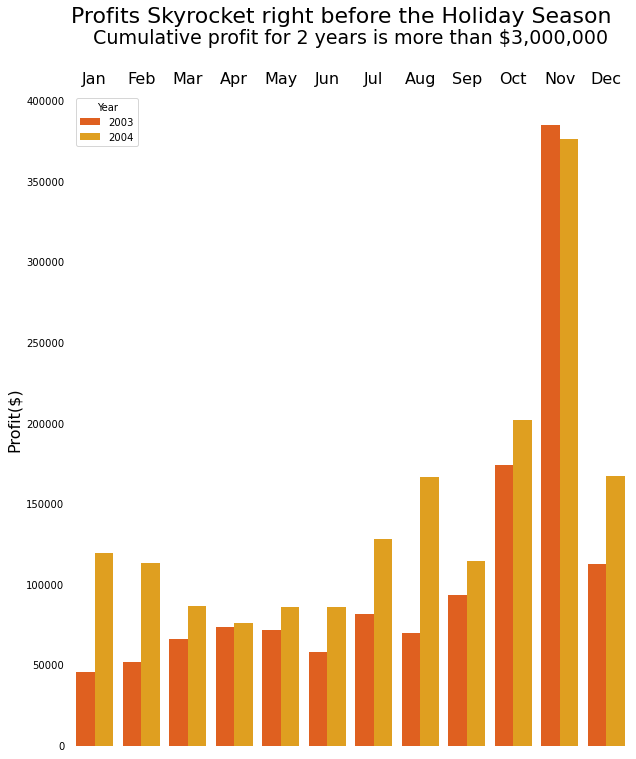

In [14]:
#Profit by Month and Year
monthly_profit_report = pd.read_sql_query(
"""SELECT CAST(SUBSTR(orderDate,1,4) AS INT)*100+CAST(SUBSTR(orderDate,6,7) AS INT) AS Year_Month,
       CAST(SUBSTR(orderDate,1,4) AS INT) AS Year,
       CAST(SUBSTR(orderDate,6,7) AS INT) AS Month,
       ROUND(SUM(Order_Profit),2) AS Profit
  FROM shipped_orders
 GROUP BY Year_Month
HAVING Year_Month < 200501""", conn
)

#print(monthly_profit_report['Profit'].sum())
plt.figure(figsize=(10,12))

#Defining the barplot
ax = sns.barplot(x = 'Month', 
                 y = 'Profit',
                 hue = 'Year',
                 data = monthly_profit_report,
                 palette = 'autumn', 
                 orient = 'v')

#Removing spines and set ticks
ax.xaxis.tick_top()
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

#Beautify plot
ax.tick_params(left=False, bottom=False,top=False,labelbottom=False)
ax.set_xticklabels(['Jan','Feb','Mar','Apr',
                    'May','Jun','Jul','Aug',
                    'Sep','Oct','Nov','Dec'],size=16)
ax.set_xlabel(None)
ax.set_ylabel("Profit($)", size=16)

ax.set_title('Cumulative profit for 2 years is more than $3,000,000\n',size=19,loc='center')
plt.suptitle("Profits Skyrocket right before the Holiday Season", size=22,x=0.50)
plt.show()

* During 2003 and 2004 the company did not experience any loss.
* In 2003 profits never went beyond 100,000 on a monthly basis till right before the holiday season when it soared to more than 5 times it monthly average in Novemeber.
* 2004 in comparison to 2003 was a much better year. Right from the beginning of the year profits soared to beyond 100,000 and gradually dropped during the subsequent months to soar significantly higher again during the holiday season. However it must be noted that sales during November were slighly less than 2003. That lost was however made up for through the profits generated during December 2004.
* Overall performance during the course of 2003 and 2004 seem quite healthy considering profits of 3,000,000 for two years.
* However, this figure is not the actual profit as it does not consider other operational costs that may have been incurred during the same time period due to lack of data.

#### F. Performance of the sales team

In [15]:
%%sql
SELECT employees.lastName||', '||employees.firstName AS Sales_Rep_Name,
       offices.territory,
       offices.city,
       SUM(customer_profit_report.no_of_orders) AS No_of_Orders,
       ROUND(SUM(customer_profit_report.profit)/SUM(customer_profit_report.no_of_orders),2) AS Profit_per_Order,
       ROUND(SUM(customer_profit_report.profit),2) AS Profit_Earned,
       ROUND((SUM(customer_profit_report.profit) * 100.0 / 
                          (SELECT SUM(profit)
                             FROM customer_profit_report)), 2) AS Percentage
   FROM customers
   JOIN customer_profit_report
     ON customers.customerNumber = customer_profit_report.customer_id
   JOIN employees
     ON customers.salesRepEmployeeNumber = employees.employeeNumber
   JOIN offices
     ON employees.officeCode=offices.officeCode
  GROUP BY employees.employeeNumber
  ORDER BY Profit_Earned DESC;

 * sqlite:///stores.db
Done.


Sales_Rep_Name,territory,city,No_of_Orders,Profit_per_Order,Profit_Earned,Percentage
"Hernandez, Gerard",EMEA,Paris,337,1264.92,426277.05,12.05
"Jennings, Leslie",NA,San Francisco,317,1292.71,409790.22,11.58
"Castillo, Pamela",EMEA,Paris,248,1257.53,311868.46,8.82
"Bott, Larry",EMEA,London,222,1227.71,272552.33,7.7
"Jones, Barry",EMEA,London,198,1275.34,252518.1,7.14
"Vanauf, George",NA,NYC,185,1285.67,237848.82,6.72
"Bondur, Loui",EMEA,Paris,177,1327.07,234891.07,6.64
"Marsh, Peter",APAC,Sydney,166,1243.39,206402.09,5.83
"Fixter, Andy",APAC,Sydney,167,1208.86,201879.08,5.71
"Tseng, Foon Yue",NA,NYC,142,1372.11,194839.92,5.51


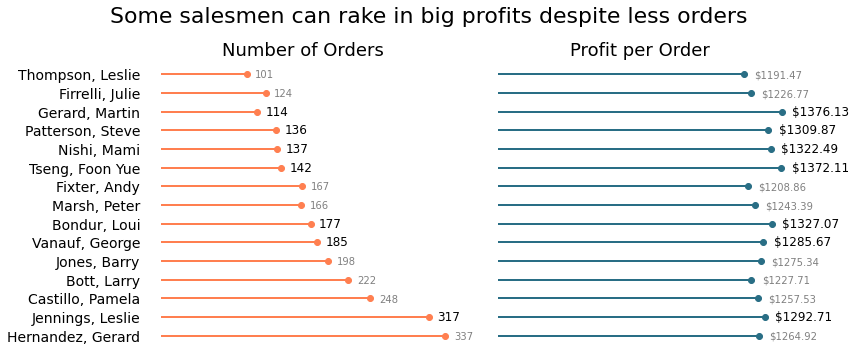

In [16]:
sales_rep_performance_report=pd.read_sql_query(
"""SELECT employees.lastName||', '||employees.firstName AS Sales_Rep_Name,
       offices.territory,
       offices.city,
       SUM(customer_profit_report.no_of_orders) AS No_of_Orders,
       ROUND(SUM(customer_profit_report.profit)/SUM(customer_profit_report.no_of_orders),2) AS Profit_per_Order,
       ROUND(SUM(customer_profit_report.profit),2) AS Profit_Earned,
       ROUND((SUM(customer_profit_report.profit) * 100.0 / 
                          (SELECT SUM(profit)
                             FROM customer_profit_report)), 2) AS Percentage
   FROM customers
   JOIN customer_profit_report
     ON customers.customerNumber = customer_profit_report.customer_id
   JOIN employees
     ON customers.salesRepEmployeeNumber = employees.employeeNumber
   JOIN offices
     ON employees.officeCode=offices.officeCode
  GROUP BY employees.employeeNumber
  ORDER BY Profit_Earned DESC;
""",conn
)
fig = plt.figure(figsize=(12,5))

#Plot number of orders
ax1 = fig.add_subplot(1,2,1)
    
#Remove spines
for each_key in ax1.spines.keys():
    ax1.spines[each_key].set_visible(False)
    
#Plot
ax1.hlines(y=sales_rep_performance_report['Sales_Rep_Name'],
           xmin=0,
           xmax=sales_rep_performance_report['No_of_Orders'],
           color='#FF7F50',
           linewidth=2)
ax1.scatter(y=sales_rep_performance_report['Sales_Rep_Name'],
            x=sales_rep_performance_report['No_of_Orders'],
            color='#FF7F50')
    
#Beautify plot
ax1.tick_params(bottom=False,left=False,labelbottom=False,labelsize=14)
    
#Select data to highlight
good_reps = [sales_rep_performance_report.iloc[i,0] for i in range(len(sales_rep_performance_report)) if sales_rep_performance_report.iloc[i,4]>1280]
size = [12 if sales_rep_performance_report.iloc[i,0] in good_reps else 10 for i in range(len(sales_rep_performance_report)) ]
palette = ['black' if sales_rep_performance_report.iloc[i,0] in good_reps else 'grey' for i in range(len(sales_rep_performance_report)) ]

#Annotate plot
for i in range(len(sales_rep_performance_report)):
    ax1.text(s=str(sales_rep_performance_report.iloc[i,3]),
             x=sales_rep_performance_report.iloc[i,3]+10,
             y=i-0.2,
             size=size[i],
             color=palette[i])
ax1.set_title('Number of Orders',size=18,loc='center')

#Plot profit per order
ax2 = fig.add_subplot(1,2,2)

#Remove spines
for each_key in ax2.spines.keys():
    ax2.spines[each_key].set_visible(False)
    
#Plot
ax2.hlines(y=sales_rep_performance_report['Sales_Rep_Name'],
           xmin=0,
           xmax=sales_rep_performance_report['Profit_per_Order'],
           color='#296E85',
           linewidth=2)
ax2.scatter(y=sales_rep_performance_report['Sales_Rep_Name'],
            x=sales_rep_performance_report['Profit_per_Order'],
            color='#296E85')

#Beautify plot
ax2.tick_params(bottom=False,left=False,
                labelbottom=False,labelleft=False)
    
#Select data to highlight
size = [12 if sales_rep_performance_report.iloc[i,4]>1280 else 10 for i in range(len(sales_rep_performance_report))]
palette = ['black' if sales_rep_performance_report.iloc[i,4]>1280 else 'grey' for i in range(len(sales_rep_performance_report)) ]

#Annotate plot
for i in range(len(sales_rep_performance_report)):
    ax2.text(s='$'+str(sales_rep_performance_report.iloc[i,4]),
             x=sales_rep_performance_report.iloc[i,4]+50,
             y=i-0.2,
             size=size[i],
             color=palette[i])
ax2.set_title('Profit per Order',size=18,loc='center')

#Title of the graph
plt.suptitle("Some salesmen can rake in big profits despite less orders", size=22,x=0.50)
plt.tight_layout()
plt.show()

* While Gerard Hernandez did bring in the most profits and the most number of orders, the average profit per order is comparatively less.
* Few salesmen whose profits per order are more than 1280 have been highlighted in the graph.
* Martin Gerarad, on the other hand, has earned comparatively less profit and bought in lesser orders. However, the profit per order is the highest when compared to all other salesmen.

#### G. Analysing whether budget must be allocated to gain new customers

In [17]:
%%sql
WITH
--#Set date to year_month format in payments
payment_year_month AS(
SELECT *, 
       CAST(SUBSTR(paymentDate, 1,4) AS INTEGER)*100 + CAST(SUBSTR(paymentDate, 6,7) AS INTEGER) AS year_month
  FROM payments
),

--#Count number of customers for each month and the total monthly sales
monthly_payment_report AS(
SELECT year_month,
       COUNT(DISTINCT customerNumber) AS number_of_customers,
       SUM(amount) AS monthly_total
  FROM payment_year_month
 GROUP BY year_month
),

--#Count number of new customers and the sales total generated by them
new_customers_report AS(
SELECT year_month AS Month,
       COUNT(DISTINCT customerNumber) AS number_of_new_customers,
       SUM(amount) AS new_customer_monthly_total,
       (SELECT number_of_customers
          FROM monthly_payment_report
         WHERE year_month = p1.year_month) AS total_customers_that_paid,
       (SELECT monthly_total
          FROM monthly_payment_report
         WHERE year_month = p1.year_month) AS total_amount_paid
  FROM payment_year_month p1
 WHERE customerNumber NOT IN (SELECT customerNumber
                                FROM payment_year_month p2
                               WHERE p2.year_month < p1.year_month)
 GROUP BY year_month
)

--#Calculate the new customers and their total sales contributions by percentage for each month 
SELECT Month,
       ROUND(number_of_new_customers*100/total_customers_that_paid) AS Percentage_New_Customers,
       ROUND(new_customer_monthly_total*100/total_amount_paid) AS Percentage_Paid_by_New_Customers
  FROM new_customers_report

 * sqlite:///stores.db
Done.


Month,Percentage_New_Customers,Percentage_Paid_by_New_Customers
200301,100.0,100.0
200302,100.0,100.0
200303,100.0,100.0
200304,100.0,100.0
200305,100.0,100.0
200306,100.0,100.0
200307,75.0,68.0
200308,66.0,54.0
200309,80.0,96.0
200310,69.0,69.0


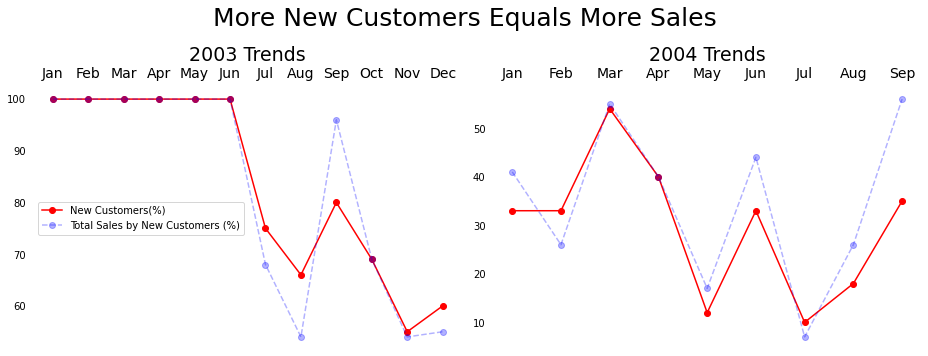

In [18]:
new_customer_report = pd.read_sql_query(
'''WITH
payment_year_month AS(
SELECT *, 
       CAST(SUBSTR(paymentDate, 1,4) AS INTEGER)*100 + CAST(SUBSTR(paymentDate, 6,7) AS INTEGER) AS year_month
  FROM payments
),

monthly_payment_report AS(
SELECT year_month,
       COUNT(DISTINCT customerNumber) AS number_of_customers,
       SUM(amount) AS monthly_total
  FROM payment_year_month
 GROUP BY year_month
),

new_customers_report AS(
SELECT year_month AS Month,
       COUNT(DISTINCT customerNumber) AS number_of_new_customers,
       SUM(amount) AS new_customer_monthly_total,
       (SELECT number_of_customers
          FROM monthly_payment_report
         WHERE year_month = p1.year_month) AS total_customers_that_paid,
       (SELECT monthly_total
          FROM monthly_payment_report
         WHERE year_month = p1.year_month) AS total_amount_paid
  FROM payment_year_month p1
 WHERE customerNumber NOT IN (SELECT customerNumber
                                FROM payment_year_month p2
                               WHERE p2.year_month < p1.year_month)
 GROUP BY year_month
)

SELECT Month AS Month,
       ROUND(number_of_new_customers*100/total_customers_that_paid) AS Percentage_New_Customers,
       ROUND(new_customer_monthly_total*100/total_amount_paid) AS Percentage_Paid_by_New_Customers
  FROM new_customers_report''',conn
)

#Plot 2003 data
data1=new_customer_report[new_customer_report['Month'].between(200301,200312)]
fig = plt.figure(figsize=(13,5))

ax1 = fig.add_subplot(1,2,1)

#Remove spines
for each_key in ax1.spines.keys():
    ax1.spines[each_key].set_visible(False)

#Set x-axis to the top
ax1.xaxis.tick_top()
ax1.tick_params(bottom=False,left=False,top=False,labeltop=True)

#Beautify plot
ax1.set_xticks(data1['Month'])
months= ['Jan','Feb','Mar','Apr',
         'May','Jun','Jul','Aug',
         'Sep','Oct','Nov','Dec']
ax1.set_xticklabels(months,size=14)

#Create plot
plt.plot('Month',
         'Percentage_New_Customers',
         data=data1,marker='o',color='red',label='New Customers(%)')

plt.plot('Month',
         'Percentage_Paid_by_New_Customers',
         data=data1,marker='o',color='blue',linestyle='--',alpha=0.3,label="Total Sales by New Customers (%)")
ax1.legend(loc='center left')
ax1.set_title('2003 Trends',size=19,loc='center')

#Plot 2004 data
data2=new_customer_report[new_customer_report['Month'].between(200401,200412)]
ax2 = fig.add_subplot(1,2,2)

#Remove spines
for each_key in ax2.spines.keys():
    ax2.spines[each_key].set_visible(False)

#Set x-axis to the top
ax2.xaxis.tick_top()
ax2.tick_params(bottom=False,left=False,top=False,
                labeltop=True,labelleft=True)

#Beautify plot
ax2.set_xticks(data2['Month'])
months2 = ['Jan','Feb','Mar','Apr',
           'May','Jun','Jul','Aug',
           'Sep']
ax2.set_xticklabels(months2,size=14)

#Plot
plt.plot('Month',
         'Percentage_New_Customers',
         data=data2,marker='o',color='red')
plt.plot('Month',
         'Percentage_Paid_by_New_Customers',
         data=data2,marker='o',color='blue',linestyle='--',alpha=0.3)
ax2.set_title('2004 Trends',size=19,loc='center')

#Title of the graph
plt.suptitle("More New Customers Equals More Sales", size=25,x=0.50)
plt.tight_layout()
plt.show()

* As we can see, sales is clearly driven by the number of new customers.
* This effect of new customers on sales in some cases seems exponential. This is specifically highlighted during the months of Aug & Sep of 2003 and the months of Feb & Jun of 2004.
* The months of Jan and Feb during 2004 prove to be an exception because despite having the same number of new percentage of new customer for both months, sales went up and subsequetly down. This may have been because it was the beginning of the year.

#### H. Identifying items that have not been sold out

Deadstock are products that have not been sold for a long time. They tend to be a cost because of the space they take up and could end up being a loss if they are dealt with because of the damage they may incur and this may cause it go completely unsold.

We will identify items that have not been sold for one year and the cost incurred by them.

In [19]:
%%sql
WITH
orders_year_month AS(
SELECT *, 
       CAST(SUBSTR(orderDate,1,4) AS INTEGER)*100 + CAST(SUBSTR(orderDate,6,7) AS INTEGER) AS year_month
  FROM orders
),

last_six_months_orders AS(
SELECT DISTINCT orderdetails.productCode
  FROM orderdetails
  JOIN orders_year_month
    ON orderdetails.orderNumber = orders_year_month.orderNumber
 WHERE orders_year_month.year_month BETWEEN 200405 AND 200505
)

SELECT products.productName AS Product,
       products.quantityinStock AS Stock_Quantity,
       ROUND(products.buyPrice * products.quantityinStock,2) AS Cost
  FROM products
 WHERE productCode NOT IN (SELECT productCode
                             FROM last_six_months_orders);

 * sqlite:///stores.db
Done.


Product,Stock_Quantity,Cost
1985 Toyota Supra,7733,440858.33


This car has not seen any demand for one year and the cost incurred by it is also quite significant.

## Recommendations

#### On Customers

* Loyal customers need to be rewarded. It would be good to start a loyalty program, if one is not in place, to ensure continued business and encourage bigger orders.
* Focus on getting existing customers to buy more because currently monthly sales seem to be more dependant on the acquisition of new customers which can be a costly affair.
* Till we can get existing customers to buy more, focus on getting new customers to keep the monthly sales numbers up. It was noticed that there were no new customers based on the existing data since Sep 2004 which should be of concern since they contribute to a lot of the current sales.

#### On Products

* Classic and Vintage car models seem to be the most popular product lines which is good. It may be helpful to associate these models to some history related to them and increase their value, thus creating more demand for them.
* It would be best to create further categorisation than the existing product line to understand why certain product lines are not so favoured. While it is true that Trains are the least favourite product lines. It may not be the case for all Train related products. Better sub-classification possibly based on their year of making or date could help to find out how customers prefer their models.
* While it good to know that there is only one product which can be considered as Deadstock, it is inadvisable to keep holding on to it considering the dent it is putting on profits. It could be considered as an add-on while selling other products to get rid of the stock and recover some part of the costs. Action against the product must be taken as soon as possible otherwise the loss due to damage might be severe.
* If it is possible and the budget allows for the it, the company should consider other types of product besides model vehilces such as stickers, action figures, toys etc. that could help them in expanding their business.

#### On Existing & Potential Markets

* The markets in the Asian region seem to be relatively unexplored. Given the rise of tech and a market boom, there are likely to be many customers willing to spend money on models atleast as a hobby.
* It would be a good investment to consider some serious expansion in to the European markets. There are many countries in European region like Spain, Norway and Switzerland that have the money and willing to spend more per order. This also holds true for Asian markets like Singapore.

#### On Salesmen

* In general salesmen seem to be doing a good job. However some are doing an even better job by encouraging customers to buy more and thus increasing profits on each order.
* salesmen must be motivated to encourage customers in their region to buy more in a single order in addition to increasing orders from customers.

#### In General

We would recommend the collection of more data for better analysis in the future. Data related to the following would be helpful:

1. Data related to overhead costs related to each order including fees and discounts
2. Data associated to credits or refunds for damaged goods
3. Customer end sales data to understand how the end customer relates to our product. This data could help the company salesmen to persuade their customers to buy more by showing end customer behavior.

## Conclusion

We analysed the data and were able to extract insights. Based on what we've seen the company has a healthy outlook in general. They are able to bring in consistent profits and their salesmen do a good job in ensuring that their profit stream is healthy. While their current choice of markets is small, they have significant oppurtunities to expand and grow and this has been highlighted in our recommendations. We have also recommended that they collect additional data about other aspects of the business which should help us in better data analysis in the future.